In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU') # 내 컴에 장착된 GPU를 list로 반환
try:
    tf.config.experimental.set_memory_growth(gpu[0], True) # GPU Memory Growth를 Enable
except RuntimeError as e:
    print(e) # Error 발생하면 Error 내용 출력

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import os
from tqdm import tqdm
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
tf.__version__

'2.10.0'

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11394662218329947245
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3435554406
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16487688138749288596
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [6]:
w, h = 7, 7
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

file_list = glob('dataset_1515/dataset/*.npz')

x_data, y_data = [], []
for file_path in tqdm(file_list):
    data = np.load(file_path)
    x_data.extend(data['inputs'])
    y_data.extend(data['outputs'])

x_data = np.array(x_data, np.float32).reshape((-1, h, w, 1))
y_data = np.array(y_data, np.float32).reshape((-1, h * w))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1 - train_ratio, random_state=2394)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=2394) 

del x_data, y_data

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

  0%|          | 0/2544 [00:00<?, ?it/s]

100%|██████████| 2544/2544 [00:01<00:00, 1970.02it/s]


(46413, 7, 7, 1) (46413, 49)
(6189, 7, 7, 1) (6189, 49)
(9282, 7, 7, 1) (9282, 49)


In [7]:
len(y_train[0])

49

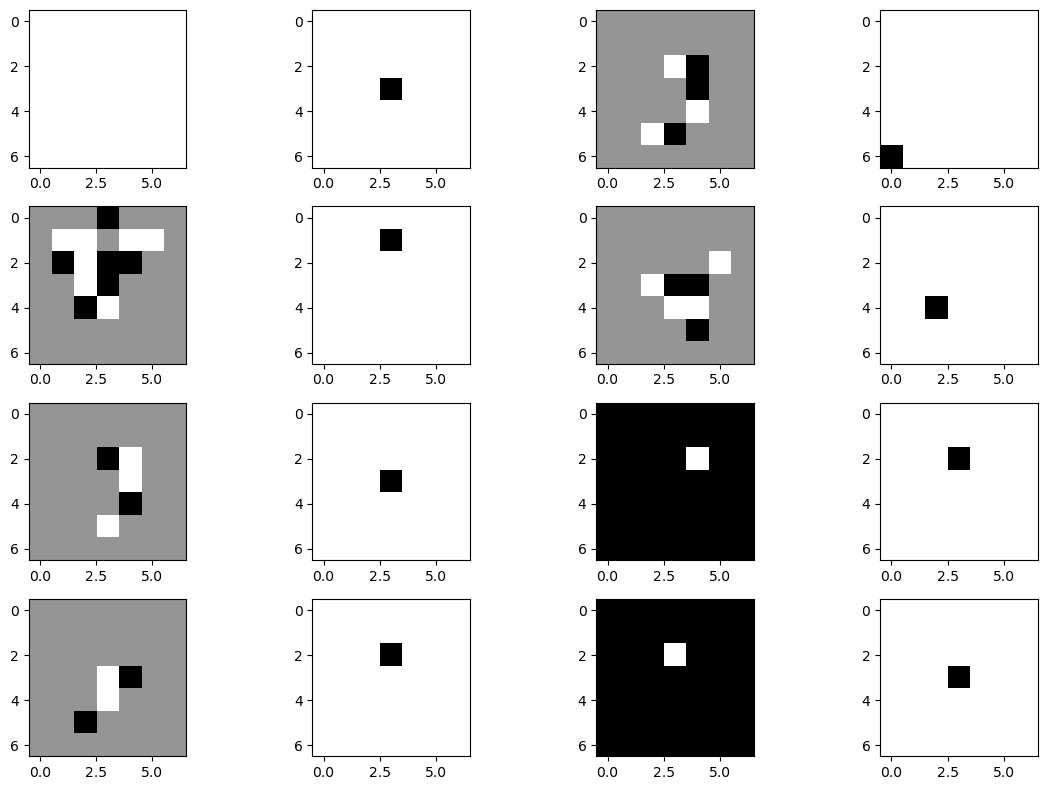

In [8]:
import matplotlib.pyplot as plt
count = 0
plt.figure(figsize=(12,8))
for n in range(8):
    count += 1
    plt.subplot(4, 4, count)
    plt.imshow(x_test[n].reshape(7, 7), cmap='Greys', interpolation='nearest')
    count += 1
    plt.subplot(4, 4, count)
    plt.imshow(y_test[n].reshape(7, 7), cmap='Greys', interpolation='nearest')

plt.tight_layout()
plt.show()

In [9]:
model = models.Sequential([
    layers.Conv2D(8, kernel_size=3, activation='relu', padding='same', input_shape=(h, w, 1)),
    layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(4, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(1, 1, activation=None, padding='same'),

    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.1),
#     layers.Dense(1000, activation='relu'),
    layers.Dense(49),
    ])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',# binary_crossentropy, sparse_categorical_crossentropy
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 8)           80        
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          7

In [10]:
start_time = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs('models', exist_ok=True)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=10,
    shuffle=True,
    callbacks=[
        ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_accuracy', patience=5)
    ],
    validation_data=(x_val, y_val),
    use_multiprocessing=True,
    workers=16
)

Epoch 1/10


: 